In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline

In [2]:
usd_gbp = pd.read_csv('USDGBP.csv', parse_dates=[0])
usd_cny = pd.read_csv('USDCNY.csv', parse_dates=[0])
usd_jpy = pd.read_csv('USDJPY.csv', parse_dates=[0])

In [3]:
# Merge all datasets to the initial dataset that has most dates
usd_dataset = usd_jpy.merge(right=usd_gbp, how='left', on='Date').merge(right=usd_cny, how='left', on='Date')

In [4]:
# Drop dates where there is one value missing
usd_dataset = usd_dataset.dropna(axis=0, how='any')

In [5]:
# Add a Ticks column to the dataframe
# usd_dataset['Ticks'] = range(len(usd_dataset.index.values), 0, -1)

# Take into consideration only two currencies
curr = 'USDJPY'
curr2 = 'USDGBP'

In [6]:
# days = 360
# usd_dataset = usd_dataset.sample(axis=0, frac=.2)
# plt.scatter(usd_dataset['Ticks'][-days:], usd_dataset['USDGBP'][-days:], marker='o', color='blue')
# plt.scatter(usd_dataset['Ticks'][-days:], usd_dataset['USDJPY'][-days:], marker='o', color='red')
# plt.scatter(usd_dataset['Ticks'][-days:], usd_dataset['USDCNY'][-days:], marker='o', color='green')
# plt.xlabel('Ticks')
# plt.ylabel('USD/XXX')

Text(0,0.5,'USDGBP')

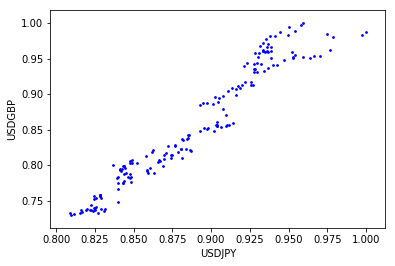

In [7]:
# usdgbp = usd_dataset['USDGBP'].rolling(center=False, window=5).mean()
# usdjpy = usd_dataset['USDJPY'].rolling(center=False, window=5).mean()

# Plot the graph of one currency in respect with the other one, NORMALIZED
days = 180
X = preprocessing.normalize(usd_dataset[curr].values.reshape(-1, 1)[-days:], axis=0, norm='max')
y = preprocessing.normalize(usd_dataset[curr2].values.reshape(-1, 1)[-days:], axis=0, norm='max')
plt.scatter(X, y, marker='o', color='blue', s=3)
plt.xlabel(curr)
plt.ylabel(curr2)

In [8]:
# Create Linear Regression model and fit the data
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, y)
print('Coefficient :', np.round(model.coef_[0][0],decimals=4),
      '\nIntercept :', np.round(model.intercept_[0], decimals=4))

Coefficient : 1.7007 
Intercept : -0.6562


Text(0,0.5,'USDGBP')

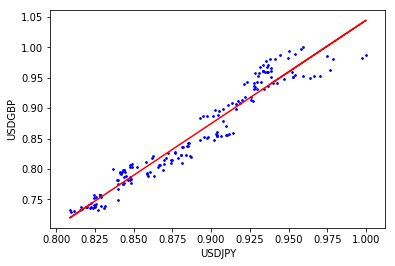

In [9]:
# Predict the data with the found best fit line and plot it
line = model.predict(X)
plt.scatter(X, y, marker='o', color='blue', s=3)
plt.plot(X, line, color='red')
plt.xlabel(curr)
plt.ylabel(curr2)

In [10]:
# GA functions
def fitness(solution):
    '''Fitness function is the Ordinary Least Squares'''
    return 1/len(X)*np.sum(np.power(y-np.concatenate((X,np.ones((X.shape[0],1))),axis=1).dot(solution.reshape(-1,1)),2))

def genPopulation(size=400):
    '''Generate population of size individuals'''
    # Coefficient and intercept in the range [-1, 1] since all data has been normalized with maximum value
    solutions = ((np.random.rand(size, 2) * 2) - 1)
    return solutions

def selectBest(solutions):
    '''Return the best 20 solution for current population'''
    fitnesses = np.apply_along_axis(fitness, 1, solutions)
    return solutions[np.argsort(fitnesses, axis=0)[:20],:]

def crossover(sol1, sol2):
    '''Perform crossover between two solutions by exchanging the intercepts and maintaining the coefficient'''
    offsprings = np.array([[sol1[0], sol2[1]]])
    offsprings = np.vstack((offsprings, [[sol2[0], sol1[1]]]))
    offsprings = np.vstack((offsprings, [sol2]))
    return offsprings

def mutation(sol):
    '''Perform mutation on the solution'''
    mutationProb = 0.15
    if np.random.rand() < mutationProb:
        sol = sol + (((np.random.rand(2) * 2) - 1) * 0.1)
    return sol

<IPython.core.display.Javascript object>


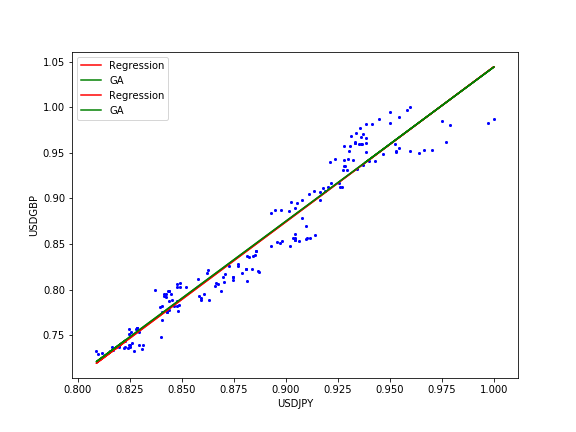

In [12]:
%matplotlib nbagg

# Perform epochs while executing the genetic algorithm
size = 400
solutions = genPopulation(size)
epochs = 400
best = []
inter_sol = []
fig = plt.figure(figsize=(8, 6))
#fig.set_tight_layout(True)
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

for i in range(epochs):
    bestSols = selectBest(solutions)
    if i != 0 and fitness(bestSols[0]) < fitness(best):
        best = bestSols[0]
    else:
        best = bestSols[0]
    predict = np.concatenate((X, np.ones((X.shape[0],1))), axis=1).dot(best.transpose())
    inter_sol.append(predict)
    ax.clear()
    plt.scatter(X, y, marker='o', color='blue', s=3)
    plt.plot(X, line, color='red', label='Regression')
    plt.plot(X, predict, color='green', label='GA')
    plt.xlabel(curr)
    plt.ylabel(curr2)
    plt.legend(loc='best')
    fig.canvas.draw()
    # Elitism
    newPopulation = np.array(best)
    for j in range(len(bestSols)-1):
        newPopulation = np.vstack((newPopulation, crossover(bestSols[j], bestSols[j+1])))
    newPopulation = np.apply_along_axis(mutation, 1, newPopulation)
    solutions = newPopulation
#print(best)

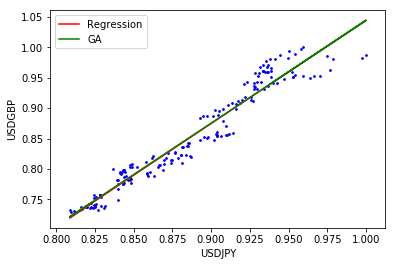

In [14]:
%matplotlib inline

# Use the best candidate solution to predict the data and plot the GA found line
predict = np.concatenate((X, np.ones((X.shape[0],1))), axis=1).dot(best.transpose())
plt.scatter(X, y, marker='o', color='blue', s=3)
plt.plot(X, line, color='red', label='Regression')
plt.plot(X, predict, color='green', label='GA')
plt.xlabel(curr)
plt.ylabel(curr2)
plt.legend(loc='best')

#### We use FuncAnimation and ImageMagick to generate a gif file of the approximation procedure

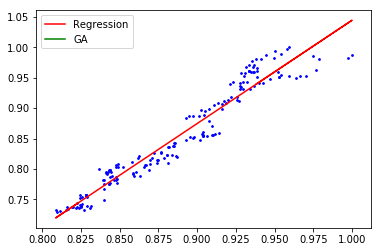

In [15]:
from matplotlib import animation, rc

fig, ax = plt.subplots()
rc('animation', html='html5')

ax.scatter(X, y, marker='o', color='blue', s=3)
ax.plot(X, line, color='red', label='Regression')
ga_line, = ax.plot([], [], color='green', label='GA')
ax.legend(loc='best')

In [16]:
def solver(i):
    ga_line.set_data(X, inter_sol[i])
    ax.set_xlabel('epoch {0}'.format(i))
    return ga_line, ax

In [17]:
anim = animation.FuncAnimation(fig, solver, frames=np.arange(0, 400), interval=80, repeat=False)

In [18]:
anim.save('ga_regression.gif', dpi=80, writer='imagemagick')